In [92]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np 
import scipy.stats as stats
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, ElasticNet, LassoCV, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

import json
import joblib
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [18]:
data_dir = os.path.join(os.path.dirname(os.getcwd()),'data')
model_dir = os.path.join(os.path.dirname(os.getcwd()),'models')
file_name = 'sample_train_v1.csv'

data_path = os.path.join(data_dir, file_name)
assert os.path.exists(data_path), f"{file_name} does not exist"


os.makedirs(model_dir, exist_ok=True)

In [3]:
df = pd.read_csv(data_path)
print(f"Data Size  {df.shape[0]}")
df.head()

Data Size  400000


,COUNT_ITEMS,MenRatio,White,Asian,Income,Poverty,Professional,Construction,Unemployment,averageoriginalprice,...,STATE_NV,STATE_OH,STATE_OK,STATE_SC,STATE_TN,STATE_TX,STATE_UT,STATE_VA,STATE_WY,train_type
0,99356,0.504501,50.826667,1.293333,45816.666667,20.193333,30.006667,13.153333,9.766667,2.396986,...,False,False,False,False,False,False,False,False,False,train
1,58278,0.491350,68.111000,1.139000,44551.670000,18.322000,30.847000,11.708000,7.965000,3.912023,...,False,False,False,False,False,False,False,False,False,val
2,40664,0.493487,71.684211,2.062406,56270.037594,14.367669,34.354135,10.771429,6.033835,3.433987,...,False,False,False,False,False,False,False,True,False,train
3,74895,0.487016,65.168657,0.711940,40271.402985,20.949254,28.095522,11.605970,9.023881,3.349904,...,False,False,False,False,False,False,False,False,False,train
4,73688,0.496876,90.285227,0.931818,51742.204545,14.507955,30.580682,9.963636,6.084091,3.891820,...,False,True,False,False,False,False,False,False,False,train


In [91]:
with open(os.path.join(model_dir,'columns.json'),'w') as f:
    json.dump(list(df_train.columns),f)

In [4]:
df_train = df[df.train_type == 'train']
df_val = df[df.train_type == 'val']
print(f"Train Size : {df_train.shape[0]}")
print(f"Validation Size : {df_val.shape[0]}")

Train Size : 320000
Validation Size : 80000


In [5]:
df_train.drop('train_type',axis=1, inplace=True)
df_val.drop('train_type',axis=1, inplace=True)

assert 'train_type' not in df_train.columns, "drop train_type column from df_train"
assert 'train_type' not in df_val.columns, "drop train_type columns from df_val"

In [6]:
X_train = df_train.drop('revenue', axis=1)
y_train = df_train[['revenue']]

X_val = df_val.drop('revenue',axis=1)
y_val = df_val[['revenue']]

print(f"X_train Shape : {X_train.shape}")
print(f"y_train Shape : {y_train.shape}")
print(f"X_val Shape : {X_val.shape}")
print(f"y_val Shape : {y_val.shape}")

X_train Shape : (320000, 1205)
y_train Shape : (320000, 1)
X_val Shape : (80000, 1205)
y_val Shape : (80000, 1)


In [7]:
def validate_model_performance(model_obj, X, y_true , data_type='val'):
    print(f"Testing {data_type} set")
    
    y_pred = model_obj.predict(X)
    
    mse_score = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"MSE Score : {round(mse_score,3)}, R2 Score : {round(r2,3)}")
    return mse_score, r2

In [8]:
perf_dict = []

## Model 1 : Linear Regression

In [10]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

train_mse, train_r2 = validate_model_performance(lr_model, X_train, y_train, data_type='train')
val_mse, val_r2 = validate_model_performance(lr_model, X_val, y_val, data_type='val')
tmp_dict={}
tmp_dict['model'] = 'LinearRegression'
tmp_dict['train_mse'] = train_mse
tmp_dict['val_mse'] = val_mse
tmp_dict['train_r2'] = train_r2
tmp_dict['val_r2'] = val_r2

perf_dict.append(tmp_dict)

Testing train set
MSE Score : 0.329, R2 Score : 0.661
Testing val set
MSE Score : 0.329, R2 Score : 0.662


In [20]:
model_name = 'linear_regression.joblib'
joblib.dump(lr_model, os.path.join(model_dir, model_name))

['/Users/dare_devil/Desktop/MLDS_2024/Quarter1/Everything_Starts_With_Data/Project/MLDS_400_G11/models/linear_regression.joblib']

## Model 2 : Ridge Regression

In [11]:
scale_cols = ['COUNT_ITEMS','MenRatio','White','Asian','Income',
              'Poverty','Professional','Construction','Unemployment',
              'averageoriginalprice','COST','RETAIL']

Z_train = X_train.copy()
Z_val = X_val.copy()

sc = StandardScaler()
sc.fit(Z_train[scale_cols])

Z_train[scale_cols] = sc.transform(Z_train[scale_cols])
Z_val[scale_cols] = sc.transform(Z_val[scale_cols])

In [12]:
num_folds = 3
alpha_list = np.logspace(-4, 4, 20)
ridge_model = RidgeCV(alphas=alpha_list, scoring='r2', cv=num_folds)
ridge_model.fit(Z_train, y_train)

print(f"Best Alpha : {float(ridge_model.alpha_)}")

train_mse, train_r2 = validate_model_performance(ridge_model, Z_train, y_train, data_type='train')
val_mse, val_r2 = validate_model_performance(ridge_model, Z_val, y_val, data_type='val')

tmp_dict={}
tmp_dict['model'] = 'RidgeRegression'
tmp_dict['train_mse'] = train_mse
tmp_dict['val_mse'] = val_mse
tmp_dict['train_r2'] = train_r2
tmp_dict['val_r2'] = val_r2

perf_dict.append(tmp_dict)

Best Alpha : 1.623776739188721
Testing train set
MSE Score : 0.329, R2 Score : 0.661
Testing val set
MSE Score : 0.329, R2 Score : 0.662


In [22]:
best_alpha = round(float(ridge_model.alpha_),3)
model_name = f'ridge_regression_{best_alpha}.joblib'
joblib.dump(ridge_model, os.path.join(model_dir, model_name))

['/Users/dare_devil/Desktop/MLDS_2024/Quarter1/Everything_Starts_With_Data/Project/MLDS_400_G11/models/ridge_regression_1.624.joblib']

## Model 3 : Lasso Regression

In [13]:
num_folds = 3
alpha_list = np.logspace(-4, 4, 20)
lasso_model = LassoCV(alphas=alpha_list, cv=num_folds)
lasso_model.fit(Z_train, y_train)

print(f"Best Alpha : {lasso_model.alpha_}")

train_mse, train_r2 = validate_model_performance(lasso_model, Z_train, y_train, data_type='train')
val_mse, val_r2 = validate_model_performance(lasso_model, Z_val, y_val, data_type='val')

tmp_dict={}
tmp_dict['model'] = 'LassoRegression'
tmp_dict['train_mse'] = train_mse
tmp_dict['val_mse'] = val_mse
tmp_dict['train_r2'] = train_r2
tmp_dict['val_r2'] = val_r2

perf_dict.append(tmp_dict)

Best Alpha : 0.0001
Testing train set
MSE Score : 0.333, R2 Score : 0.657
Testing val set
MSE Score : 0.332, R2 Score : 0.659


In [14]:
perf_dict

[{'model': 'LinearRegression',
  'train_mse': 0.32914539304427093,
  'val_mse': 0.32911126955426573,
  'train_r2': 0.661335917164788,
  'val_r2': 0.661949155370896},
 {'model': 'RidgeRegression',
  'train_mse': 0.3292248474042057,
  'val_mse': 0.3289697121191184,
  'train_r2': 0.6612541650318303,
  'val_r2': 0.662094557898679},
 {'model': 'LassoRegression',
  'train_mse': 0.333250349463725,
  'val_mse': 0.3320212855101733,
  'train_r2': 0.6571122478373369,
  'val_r2': 0.6589600953088961}]

In [25]:
best_alpha = float(lasso_model.alpha_)
model_name = f'lass_regression_alpha_{best_alpha}.joblib'
joblib.dump(lasso_model, os.path.join(model_dir, model_name))

['/Users/dare_devil/Desktop/MLDS_2024/Quarter1/Everything_Starts_With_Data/Project/MLDS_400_G11/models/lass_regression_alpha_0.0001.joblib']

## Model 4: Xgboost Regressor

In [35]:
xg_reg = XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 8, 
                          alpha = 10, 
                          n_estimators = 150)
xg_reg.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, ...)

In [36]:
train_mse, train_r2 = validate_model_performance(xg_reg, X_train, y_train, data_type='train')
val_mse, val_r2 = validate_model_performance(xg_reg, X_val, y_val, data_type='val')

Testing train set
MSE Score : 0.267, R2 Score : 0.725
Testing val set
MSE Score : 0.272, R2 Score : 0.72


In [43]:
param_grid = {
    'n_estimators': [100, 200],            # Number of boosting rounds
    'max_depth': [5, 7, 9],               # Maximum tree depth
    'learning_rate': [0.01, 0.1, 0.3],    # Step size shrinkage
    'subsample': [0.8, 0.9, 1.0],         # Fraction of samples used for training
    'colsample_bytree': [0.8, 0.9, 1.0],  # Fraction of features used for training in each tree
}

# Create an XGBoost regressor
xgb_regressor = XGBRegressor(random_state=42)

# Perform k-fold cross-validation to find the best hyperparameters
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1, verbose=True)

# Fit the model to the data and find the best hyperparameters
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding cross-validated score
best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)  # Root Mean Squared Error

print("Best Hyperparameters:", best_params)
print("Best RMSE:", best_score)

# Now you can train your final XGBoost model using the best hyperparameters
best_xgb_regressor = xgb.XGBRegressor(random_state=42, **best_params)
best_xgb_regressor.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 200, 'subsample': 1.0}
Best RMSE: 0.5115724587112536


NameError: name 'xgb' is not defined

In [49]:
train_mse, train_r2 = validate_model_performance(best_xgb_regressor, X_train, y_train, data_type='train')
val_mse, val_r2 = validate_model_performance(best_xgb_regressor, X_val, y_val, data_type='val')

Testing train set
MSE Score : 0.21, R2 Score : 0.784
Testing val set
MSE Score : 0.256, R2 Score : 0.737


In [50]:
tmp_dict={}
tmp_dict['model'] = 'XgBoost'
tmp_dict['train_mse'] = train_mse
tmp_dict['val_mse'] = val_mse
tmp_dict['train_r2'] = train_r2
tmp_dict['val_r2'] = val_r2

perf_dict.append(tmp_dict)

In [51]:
model_name = f'xgboost.joblib'
joblib.dump(best_xgb_regressor, os.path.join(model_dir, model_name))

['/Users/dare_devil/Desktop/MLDS_2024/Quarter1/Everything_Starts_With_Data/Project/MLDS_400_G11/models/xgboost.joblib']

In [54]:
with open(os.path.join(model_dir, 'perf_dict.json') , 'w') as f:
    json.dump(perf_dict, f)

## Model 5: Decision Tree Regressor

In [70]:
# Define the parameter grid
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'min_impurity_decrease': [0.0, 0.1, 0.2]
}

# Create a Decision Tree Regressor
tree_regressor = DecisionTreeRegressor()

# Create a KFold cross-validation object with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=tree_regressor, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to your data
grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Mean Squared Error:", -grid_search.best_score_)


# Get the best estimator (model) from the grid search
best_tree_regressor = grid_search.best_estimator_

# Fit the best estimator to your data
best_tree_regressor.fit(X_train, y_train) 

Best Hyperparameters: {'max_depth': 15, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Mean Squared Error: 0.29864754422288964


DecisionTreeRegressor(max_depth=15, min_samples_leaf=4, min_samples_split=10)

In [72]:
train_mse, train_r2 = validate_model_performance(best_tree_regressor, X_train, y_train, data_type='train')
val_mse, val_r2 = validate_model_performance(best_tree_regressor, X_val, y_val, data_type='val')

tmp_dict={}
tmp_dict['model'] = 'Decision Tree'
tmp_dict['train_mse'] = train_mse
tmp_dict['val_mse'] = val_mse
tmp_dict['train_r2'] = train_r2
tmp_dict['val_r2'] = val_r2

perf_dict.append(tmp_dict)

Testing train set
MSE Score : 0.241, R2 Score : 0.752
Testing val set
MSE Score : 0.29, R2 Score : 0.702


In [80]:
perf_dict

[{'model': 'LinearRegression',
  'train_mse': 0.32914539304427093,
  'val_mse': 0.32911126955426573,
  'train_r2': 0.661335917164788,
  'val_r2': 0.661949155370896},
 {'model': 'RidgeRegression',
  'train_mse': 0.3292248474042057,
  'val_mse': 0.3289697121191184,
  'train_r2': 0.6612541650318303,
  'val_r2': 0.662094557898679},
 {'model': 'LassoRegression',
  'train_mse': 0.333250349463725,
  'val_mse': 0.3320212855101733,
  'train_r2': 0.6571122478373369,
  'val_r2': 0.6589600953088961},
 {'model': 'XgBoost',
  'train_mse': 0.21035668811841887,
  'val_mse': 0.2558575898551119,
  'train_r2': 0.7835599210702151,
  'val_r2': 0.7371926082250853},
 {'model': 'Decision Tree',
  'train_mse': 0.2409274678681985,
  'val_mse': 0.2898945774401828,
  'train_r2': 0.7521050524792887,
  'val_r2': 0.7022310816345584}]

In [ ]:
model_name = f'decision_Tree_Regressor.joblib'
joblib.dump(best_tree_regressor, os.path.join(model_dir, model_name))

## Random Forest Regressor

In [81]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [82]:
train_mse, train_r2 = validate_model_performance(rf, X_train, y_train, data_type='train')
val_mse, val_r2 = validate_model_performance(rf, X_val, y_val, data_type='val')

Testing train set
MSE Score : 0.056, R2 Score : 0.942
Testing val set
MSE Score : 0.278, R2 Score : 0.715


In [ ]:
train_mse, train_r2 = validate_model_performance(best_random_forest_regressor, X_train, y_train, data_type='train')
val_mse, val_r2 = validate_model_performance(best_random_forest_regressor, X_val, y_val, data_type='val')

tmp_dict={}
tmp_dict['model'] = 'RandomForest'
tmp_dict['train_mse'] = train_mse
tmp_dict['val_mse'] = val_mse
tmp_dict['train_r2'] = train_r2
tmp_dict['val_r2'] = val_r2

perf_dict.append(tmp_dict)

In [ ]:
print(perf_dict)

In [ ]:
model_name = f'RandomForest_Regressor.joblib'
joblib.dump(best_random_forest_regressor, os.path.join(model_dir, model_name))

In [95]:
perf_dict = json.load(open(os.path.join(model_dir, 'perf_dict.json')))
perf_dict

[{'model': 'LinearRegression',
  'train_mse': 0.32914539304427093,
  'val_mse': 0.32911126955426573,
  'train_r2': 0.661335917164788,
  'val_r2': 0.661949155370896},
 {'model': 'RidgeRegression',
  'train_mse': 0.3292248474042057,
  'val_mse': 0.3289697121191184,
  'train_r2': 0.6612541650318303,
  'val_r2': 0.662094557898679},
 {'model': 'LassoRegression',
  'train_mse': 0.333250349463725,
  'val_mse': 0.3320212855101733,
  'train_r2': 0.6571122478373369,
  'val_r2': 0.6589600953088961},
 {'model': 'XgBoost',
  'train_mse': 0.21035668811841887,
  'val_mse': 0.2558575898551119,
  'train_r2': 0.7835599210702151,
  'val_r2': 0.7371926082250853},
 {'model': 'Decision Tree',
  'train_mse': 0.2409274678681985,
  'val_mse': 0.2898945774401828,
  'train_r2': 0.7521050524792887,
  'val_r2': 0.7022310816345584},
 {'model': 'RandomForest',
  'train_mse': 0.056,
  'val_mse': 0.278,
  'train_r2': 0.942,
  'val_r2': 0.715}]

In [96]:
perf_df = pd.DataFrame(perf_dict)
perf_df.head()

,model,train_mse,val_mse,train_r2,val_r2
0,LinearRegression,0.329145,0.329111,0.661336,0.661949
1,RidgeRegression,0.329225,0.328970,0.661254,0.662095
2,LassoRegression,0.333250,0.332021,0.657112,0.658960
3,XgBoost,0.210357,0.255858,0.783560,0.737193
4,Decision Tree,0.240927,0.289895,0.752105,0.702231


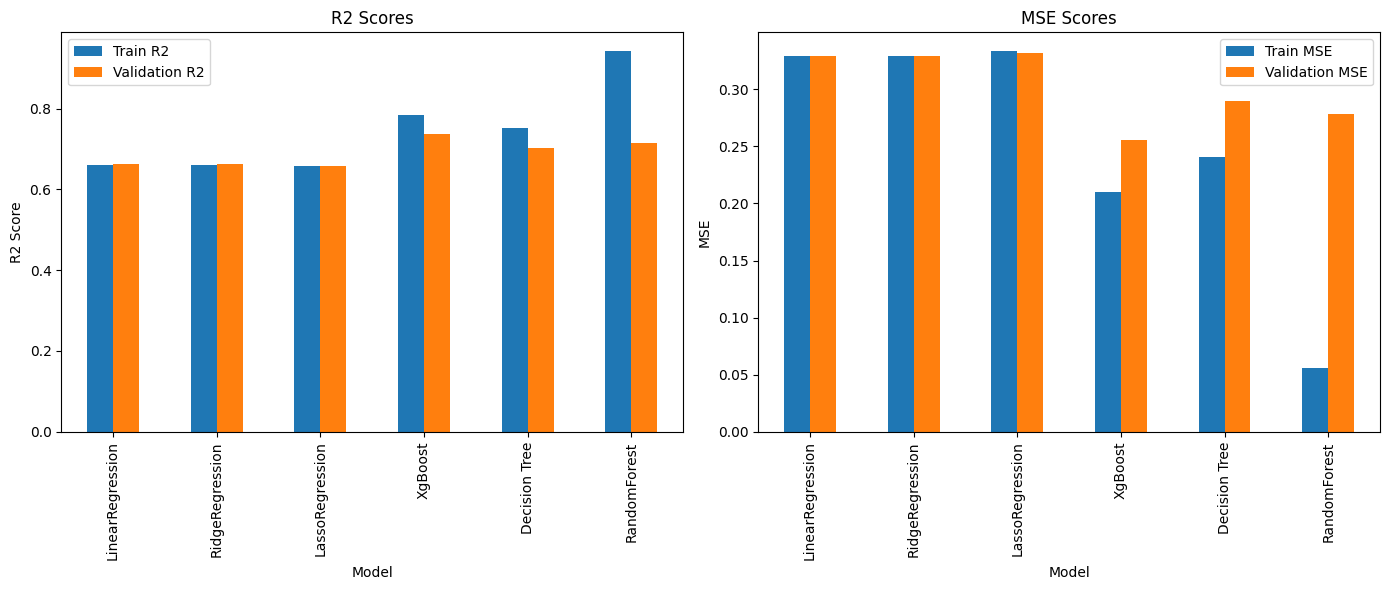

In [99]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Histogram for R2 scores
r2_scores = perf_df[['model', 'train_r2', 'val_r2']]
r2_scores.plot(x='model', kind='bar', ax=axes[0])
axes[0].set_title('R2 Scores')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('R2 Score')
axes[0].legend(['Train R2', 'Validation R2'])

# Histogram for MSE
mse_scores = perf_df[['model', 'train_mse', 'val_mse']]
mse_scores.plot(x='model', kind='bar', ax=axes[1])
axes[1].set_title('MSE Scores')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('MSE')
axes[1].legend(['Train MSE', 'Validation MSE'])

# Adjust layout
plt.tight_layout()
plt.show()

## Conclusion

Based on the above Bar Plots

- Top 2 best performing models with highest R2 and lowest MSE are 
    - **Xgboost Regressor**
        - R2 = 73.72%
        - MSE = 0.2556)
    - **Random Forest Regressor**
        - R2 = 71.5%
        - MSE = 0.278)
    
We will be using Xgboost Regressor for our Final results evaluations